In [ ]:
#Required packages
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
#Function to plot the images
def plot_multiple_images(images, n_cols=None, epoch=0):
  """Visualize fake image"""
  display.clear_output(wait=False)
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)

  fig = plt.figure(figsize=(n_cols, n_rows))
  fig.suptitle(f"Epochs {epoch}", fontsize="x-large")
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(image, cmap="binary")
    # save image
    plt.axis("off")
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

In [ ]:
# load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
BATCH_SIZE = 128
#Data loader
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)

In [ ]:
# declare shape of the noise dataset
random_normal_dimensions = 32

# build the generator model
generator = keras.models.Sequential([
  keras.layers.Dense(64, activation="selu", input_shape=[random_normal_dimensions]),
  keras.layers.Dense(128, activation="selu"),
  keras.layers.Dense(28 * 28, activation="sigmoid"),
  keras.layers.Reshape([28, 28])
])

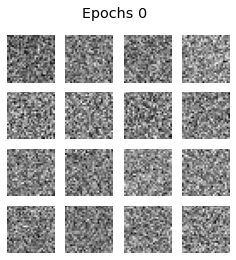

In [ ]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, random_normal_dimensions])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_multiple_images(test_image, n_cols=4)

In [ ]:
# build the discriminator model
discriminator = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.Dense(128, activation="selu"),
 keras.layers.Dense(64, activation="selu"),
 keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
#Construct the GAN model by combining generator and discriminator
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
#Compile the model with loss and optimizer algorithm
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
  """Defines the two-phase training loop of the GAN
  Args:
    gan -- the GAN model which has the generator and discriminator
    dataset -- the training set of real image
    random_normal_dimensions -- dimensionality of the input to the generator
    n_epochs -- number of epochs
  """
  # get the two sub networks from the GAN model
  generator, discriminator = gan.layers

  # start loop
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))       
    for real_images in dataset:
        # infer batch size from the training batch
        batch_size = real_images.shape[0]

        # Train the discriminator - PHASE 1
        # Create the noise
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
        
        # Use the noise to generate fake images
        fake_images = generator(noise)
        
        # Create a list by concatenating the fake images with the real ones
        mixed_images = tf.concat([fake_images, real_images], axis=0)
        
        # Create the labels for the discriminator
        # 0 for the fake images
        # 1 for the real images
        discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # Ensure that the discriminator is trainable
        discriminator.trainable = True
        
        # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
        discriminator.train_on_batch(mixed_images, discriminator_labels)
        
        # Train the generator - PHASE 2
        # create a batch of noise input to feed to the GAN
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

        # label all generated images to be "real"
        generator_labels = tf.constant([[1.]] * batch_size)

        # Freeze the discriminator
        discriminator.trainable = False

        # Train the GAN on the noise with the labels all set to be true
        gan.train_on_batch(noise, generator_labels)

    # plot the fake images used to train the discriminator
    plot_multiple_images(fake_images, 8, epoch)

    plt.show()   

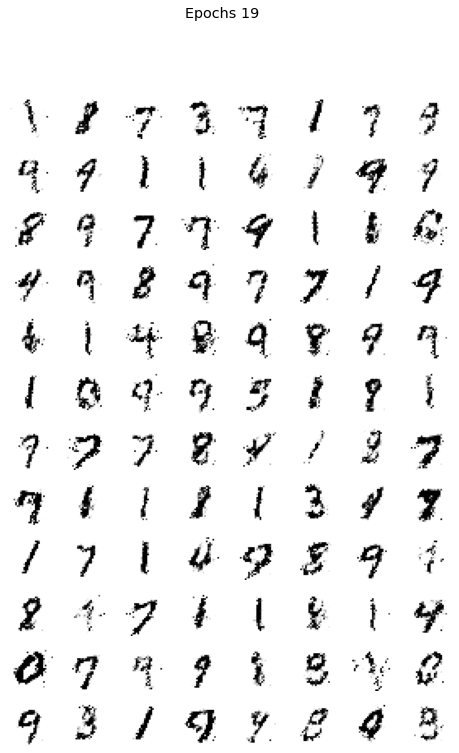

In [ ]:
#Train the model by calling training function
train_gan(gan, dataset, random_normal_dimensions, n_epochs=20)